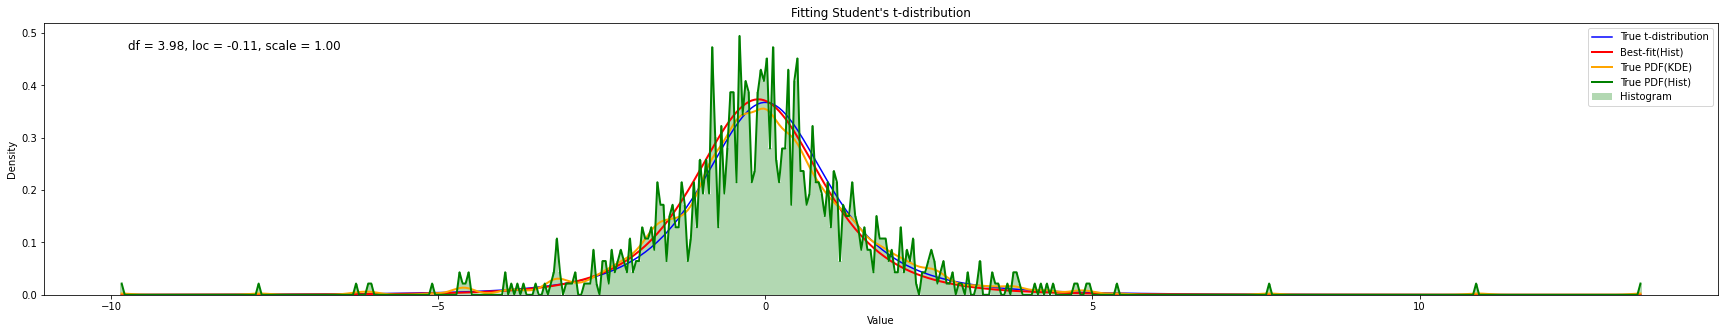

In [113]:
import numpy as np
import pandas as pd
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import t, norm
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde

def analysis_demo():
    # as degree of freedom df increase: Cauchy pdf(df=1) -> student-t pdf -> normal distribution(df=inf)
    # Generate some sample data from a t-distribution
    np.random.seed(int(time.time()))
    data = t.rvs(df=3, size=1000)

    HIST_BIN = 500
    KDE_BW = 0.1
    #   Estimate the PDF using
    #       1. Kernel Density Estimation(KDE) (can smooth, or even over-oscillate(worse than over-fit))
    #       2. histogram-based method
    kde = gaussian_kde(data, bw_method=KDE_BW)  # less bandwidth == more fitting (default is 'scott')
    pdf_values_kde = kde(data)

    hist, bins = np.histogram(data, bins=HIST_BIN, density=True) # density = output pdf or number in each bin
    bin_centers = (bins[:-1] + bins[1:]) / 2
    pdf_values_hist = np.interp(data, bin_centers, hist)

    # PDF (probability density function) of a t-distribution
    def t_pdf(x, df, loc, scale): # samples(x) -> pdf(y) at x
        return t.pdf(x, df, loc=loc, scale=scale)

    # Fit the sample data to the function
    params, cov = curve_fit(t_pdf, 
                            data, 
                            pdf_values_hist, 
                            p0=[1, np.mean(data), np.std(data)], # initial guess
                            method='lm' # Levenberg–Marquardt algorithm (damped least-squares (DLS)) 
                            )

    plt.figure(figsize=(30, 5))  # Adjust the figure size as needed

    # Plot the histogram of the data
    plt.hist(data, bins=HIST_BIN, density=True, alpha=0.3, color='g', label='Histogram')

    x = bin_centers
    plt.plot(x, t_pdf(x, df=3, loc=0, scale=1), color='blue', linestyle='-', label='True t-distribution')
    plt.plot(x, t_pdf(x, *params), color='red', linestyle='-', linewidth=2, label='Best-fit(Hist)')
    plt.plot(x, kde(x), color='orange', linestyle='-', linewidth=2, label='True PDF(KDE)')
    plt.plot(x, hist, color='green', linestyle='-', linewidth=2, label='True PDF(Hist)')

    fit_params_str = f"df = {params[0]:.2f}, loc = {params[1]:.2f}, scale = {params[2]:.2f}"
    plt.text(0.05, 0.9, fit_params_str, transform=plt.gca().transAxes, fontsize=12)

    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Fitting Student\'s t-distribution')
    plt.legend()
    plt.show()

analysis_demo()

In [168]:
from matplotlib.font_manager import FontProperties
from _2_csv_data_parse import get_exchange

# path========================================================================================
assets_list = [
    '1沪A_不包括科创板', # 1698
    '2深A_不包括创业板', # 1505
    '3科创板', # 569
    '4创业板', # 1338
    '5北A_新老三板', # 244
    #'6上证股指期权',
    #'7深证股指期权',
]

modpath = os.getcwd()
csv_path = f'{modpath}/../data/'
log = f'{modpath}/logfile.txt'
assets_path_list = [csv_path + asset for asset in assets_list]

def parse_csv_metadata():
    HIST_BIN = 1000
    HIST_RANGE = (3,97)
    fig, axs = plt.subplots(2, 1, figsize=(30, 20))
    plt.rcParams['font.family'] = ['SimSun', 'sans-serif']  # SimSun is a common font that supports GBK characters

    for assets_path in assets_path_list:
        missing_data_symbols = []
        during_day_return = []
        over_night_return = []
        assets = assets_path.split('/')[-1]
        for asset_csv_name in tqdm(os.listdir(assets_path), desc=f'{assets}'):
            if asset_csv_name.endswith('.txt'):
                asset_csv_path = os.path.join(assets_path, asset_csv_name)
                num_lines = sum(1 for _ in open(asset_csv_path, encoding='gbk'))
                info_lines_num = [0, 2, num_lines - 2]  # 1st, 3rd, the 2nd_last line
                info_lines = pd.read_csv(asset_csv_path, encoding='gbk', sep='\s+', skiprows=lambda x: x not in info_lines_num, header=None)
                data_lines_num = range(2,num_lines-1)
                data_lines = pd.read_csv(asset_csv_path, encoding='gbk', sep='\s+', skiprows=lambda x: x not in data_lines_num, header=None)
                if(num_lines<10):
                    missing_data_symbols.append(info_lines.iloc[0, 1])
                    continue
                for i in range(len(data_lines)):
                    data_line = data_lines.iloc[i, 0].split(',')
                    day_close = float(data_line[4])
                    day_open = float(data_line[1])
                    during_day_return.append(round(day_close/day_open, 5)) # close/open
                    if i != 0:
                        over_night_return.append(round(day_open/last_close, 5)) # open/last close
                    last_close = day_close
                                    # open = data_lines.iloc[i, 0].split(',')[1]
                                    # close = data_lines.iloc[i, 0].split(',')[4]
                                    # asset_csv_name.split('.')[0],   # 'asset_file_name'
                                    # lines.iloc[0, 0],               # 'code'
                                    # get_exchange(lines.iloc[0, 0]), # 'exchange'
                                    # lines.iloc[0, 1],               # 'symbol'
                                    # lines.iloc[1, 0].split(',')[0], # 'start_date'
                                    # lines.iloc[-1, 0].split(',')[0],# 'end_date'

        print('missing_data: ', missing_data_symbols)
        hist_range=(np.percentile(during_day_return, HIST_RANGE[0]), np.percentile(during_day_return, HIST_RANGE[1]))
        hist, bins = np.histogram(during_day_return, range=hist_range, bins=HIST_BIN) # density cannot be used here
        hist_pdf = [h / sum(hist) for h in hist]
        bin_centers = (bins[:-1] + bins[1:]) / 2
        axs[0].plot(bin_centers, hist_pdf, color='green', linestyle='-', linewidth=2, label=f'hist pdf({assets}), mean:{np.mean(during_day_return):.3f}')

        hist_range=(np.percentile(over_night_return, HIST_RANGE[0]), np.percentile(over_night_return, HIST_RANGE[1]))
        hist, bins = np.histogram(over_night_return, range=hist_range, bins=HIST_BIN) # density cannot be used here
        hist_pdf = [h / sum(hist) for h in hist]
        bin_centers = (bins[:-1] + bins[1:]) / 2
        axs[1].plot(bin_centers, hist_pdf, color='green', linestyle='-', linewidth=2, label=f'hist pdf({assets}), mean:{np.mean(over_night_return):.3f}')

    axs[0].set_title('Day_Return')
    axs[1].set_title('Over_Night_Return')
    for ax in axs:
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend(fontsize=20, prop={'family': 'Times New Roman'})

    plt.tight_layout()
    plt.show()
parse_csv_metadata()

1沪A_不包括科创板:   8%|▊         | 141/1698 [00:09<01:39, 15.65it/s]